# Project 12: Time Series

## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

**The RMSE metric on the test set should not be more than 48.**

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

- The data is stored in file `taxi.csv`.
- The number of orders is in the '*num_orders*' column.

### Library Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from warnings import simplefilter

# 1. Preparation

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Analysis

Text(0, 0.5, 'Number of Rides')

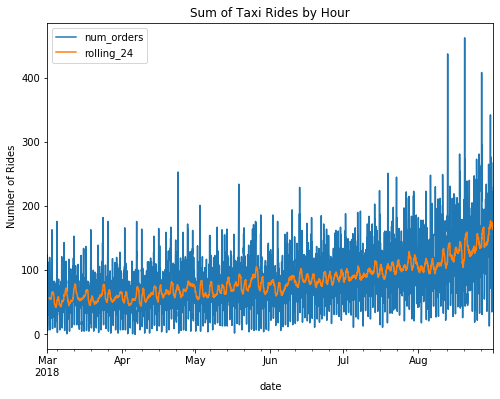

In [6]:
rides = df.copy()
rides2 = df.copy()

data = df.copy()
data['rolling_24'] = data.rolling(24).mean()
data.plot(figsize=(8,6))
plt.title('Sum of Taxi Rides by Hour')
plt.xlabel('date')
plt.ylabel('Number of Rides')

Text(0.5, 1.0, 'August')

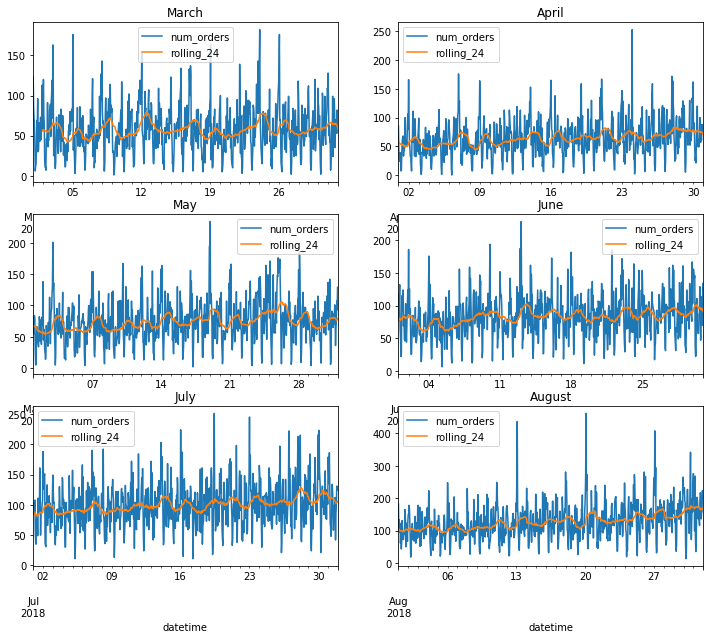

In [7]:
# Visualize in sections

plt.figure(figsize=(12,10))

plt.subplot(321)
data['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('March')

plt.subplot(322)
data['2018-04-01':'2018-04-30'].plot(ax=plt.gca())
plt.title('April')

plt.subplot(323)
data['2018-05-01':'2018-05-31'].plot(ax=plt.gca())
plt.title('May')

plt.subplot(324)
data['2018-06-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('June')

plt.subplot(325)
data['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('July')

plt.subplot(326)
data['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('August')

- Looking at the above data and charts:
    - We see general spikes and dips every couple days in each
    - August had the highest spike days for number of rides
    - In general, over the course of the times series, the number of rides is trending positively, but not very strong
    - It seems to be increasing faster in August

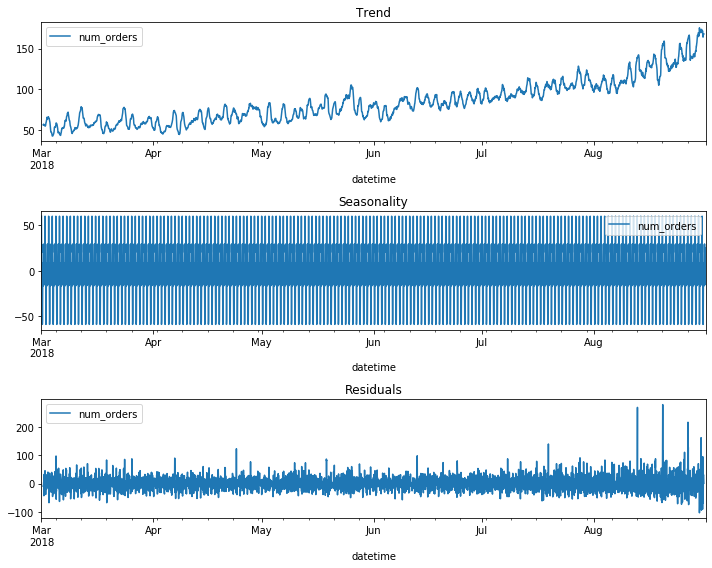

In [8]:
decomp = seasonal_decompose(df)

plt.figure(figsize=(10, 8))
plt.subplot(311)
decomp.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomp.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomp.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

- Similar finding to above
    - slight positive trend in the number of rides
    - Residuals highest in August, similar to before where August had the highest spikes

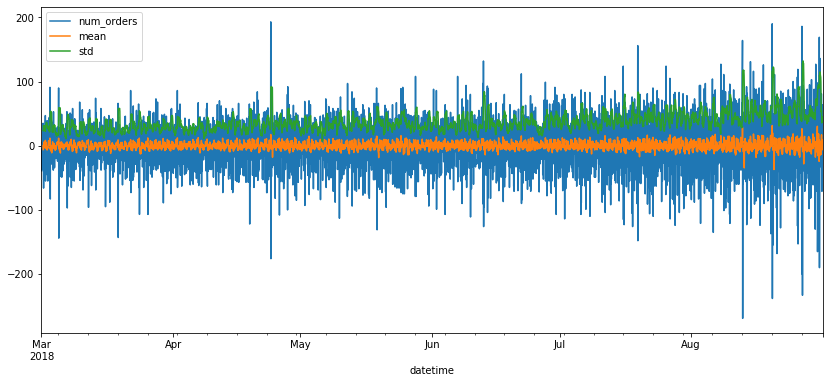

In [9]:
# Time-series Differences makes the data more stationary

df = df - df.shift()

df['mean'] = df['num_orders'].rolling(10).mean()
df['std'] = df['num_orders'].rolling(10).std()
df.plot(figsize=(14,6))

- Here we see the increase in the standard deviation toward the end which again is relating to the larger spikes in August
- There is also some more fluctuation in the mean in August

# 3. Training

In [10]:
rides.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
# Creating new features:

rides['hour'] = rides.index.hour
rides['year'] = rides.index.year
rides['day'] = rides.index.day
rides['month'] = rides.index.month
rides['dayofweek'] = rides.index.dayofweek

for lag in range(1, 21):
    rides['lag_{}'.format(lag)] = rides['num_orders'].shift(lag)

rides['rolling_mean_5'] = rides['num_orders'].shift().rolling(5).mean()
rides['rolling_mean_12'] = rides['num_orders'].shift().rolling(12).mean()
rides['rolling_mean_24'] = rides['num_orders'].shift().rolling(24).mean()


In [12]:
rides = rides.dropna()
rides.head(2)

,num_orders,hour,year,day,month,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean_5,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,2018,2,3,4,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,68.6,56.583333,56.833333
2018-03-02 01:00:00,120,1,2018,2,3,4,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,77.6,61.583333,55.416667


In [13]:
# Splitting data

train, v = train_test_split(rides, shuffle=False, test_size=0.2)
val, test = train_test_split(v, shuffle=False, test_size=0.5)

xt = train.drop('num_orders', axis=1)
yt = train['num_orders']

xv = val.drop('num_orders', axis=1)
yv = val['num_orders']

xtest = test.drop('num_orders', axis=1)
ytest = test['num_orders']

# Creating a full training set for final models to encompass both train and validation data

xtrain = pd.concat([xt, xv])
ytrain = pd.concat([yt, yv])

In [14]:
print('Set 1 Shapes:')
print(xt.shape)
print(yt.shape)
print(xv.shape)
print(yv.shape)
print(xtest.shape)
print(ytest.shape)

Set 1 Shapes:
(3513, 28)
(3513,)
(439, 28)
(439,)
(440, 28)
(440,)


In [15]:
# Using Median Value for num_orders

p_median = np.ones(yv.shape) * yt.median()
print("Val RMSE:", np.sqrt(mean_squared_error(yv, p_median)))

Val RMSE: 59.96346647812227


In [16]:
# Previous datapoint Prediction:

p_prev = xv.shift()
p_prev.iloc[0] = xt.iloc[-1]

print("Val RMSE:", np.sqrt(mean_squared_error(xv, p_prev)))

Val RMSE: 39.53430297431293


### Linear Regression:

In [17]:
# Linear Regression Training

lr_mod = LinearRegression()
lr_mod.fit(xt, yt)
lr_p = lr_mod.predict(xv)
lr_rmse = np.sqrt(mean_squared_error(yv, lr_p))

print('Val RMSE:', lr_rmse)

Val RMSE: 35.91228853770497


### Random Forest

In [18]:
# Random Forest Tuning max_depth:
simplefilter(action='ignore', category=FutureWarning)

for i in range(2, 23, 4):
    rf = RandomForestRegressor(random_state=123, max_depth=i)
    rf.fit(xt, yt)
    rfp = rf.predict(xv)
    print('depth', i, '| Val RMSE:', np.sqrt(mean_squared_error(yv, rfp)))

depth 2 | Val RMSE: 48.39877563446387
depth 6 | Val RMSE: 35.291251896784075
depth 10 | Val RMSE: 32.97777604774453
depth 14 | Val RMSE: 31.837713171427602
depth 18 | Val RMSE: 31.707585109543125
depth 22 | Val RMSE: 31.763951094111054


In [19]:
# Tuned Model Training

rf_model = RandomForestRegressor(random_state=123, max_depth=18)
rf_model.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

### LightGBM:

In [20]:
# LightGBM Training max_depth + num_leaves:

for i, j in [(35,35), (40,30), (40,40), (40,50), (45,45)]:
    lg = lgb.LGBMRegressor(random_state=123, max_depth=i, num_leaves=j)
    lg.fit(xt, yt)
    lgp = lg.predict(xv)
    print('depth:', i, '| leaves:', j, '| Val RMSE:', np.sqrt(mean_squared_error(yv, lgp)))

depth: 35 | leaves: 35 | Val RMSE: 31.437007326589747
depth: 40 | leaves: 30 | Val RMSE: 31.907072845406027
depth: 40 | leaves: 40 | Val RMSE: 31.28474318954035
depth: 40 | leaves: 50 | Val RMSE: 31.712689199791665
depth: 45 | leaves: 45 | Val RMSE: 31.447305016636975


In [21]:
# Tuned LGBM Model:

lg_model = lgb.LGBMRegressor(random_state=123, max_depth=40, num_leaves=40)
lg_model.fit(xtrain, ytrain)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=40,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=40, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### XGBoost:

In [22]:
# XGBoost Tuning max_depth, n_estimators, learning_rate:

for i, j, y in [(1, 50, 0.2), (2, 100, 0.3), (3, 200, 0.4)]:
    xg = xgb.XGBRegressor(max_depth=i, n_estimators=j, learning_rate=y, verbosity=0, random_state=123)
    xg.fit(xt, yt)
    xgp = xg.predict(xv)
    print('depth:', i, '| estimators', j, '| rate', y, '| Val RMSE:', np.sqrt(mean_squared_error(yv, xgp)))

depth: 1 | estimators 50 | rate 0.2 | Val RMSE: 41.19651477122888
depth: 2 | estimators 100 | rate 0.3 | Val RMSE: 32.327397096757814
depth: 3 | estimators 200 | rate 0.4 | Val RMSE: 34.01069075458629


In [23]:
# Tuned XGBoost Model:

xg_model = xgb.XGBRegressor(max_depth=2, n_estimators=100, learning_rate=0.3, verbosity=0, random_state=123)
xg_model.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

# 4. Testing

In [24]:
# Median Method:

p_median_test = np.ones(ytest.shape) * yt.median()
p_med_rmse = np.sqrt(mean_squared_error(ytest, p_median_test))
print("Test RMSE:", p_med_rmse)

Test RMSE: 89.45454660938654


In [25]:
# Previous data prediction:

pp_test = ytest.shift()
pp_test.iloc[0] = yt.iloc[-1]
pp_rmse = np.sqrt(mean_squared_error(ytest, pp_test))

print("Test RMSE:", pp_rmse)

Test RMSE: 58.94224831446147


In [26]:
# Linear Regression Test

lr_p_test = lr_mod.predict(xtest)
lr_rmse_test = np.sqrt(mean_squared_error(ytest, lr_p_test))

print('Test RMSE:', lr_rmse_test)

Test RMSE: 47.23082090494442


In [27]:
rf_pred = rf_model.predict(xtest)
rf_rmse = np.sqrt(mean_squared_error(ytest, rf_pred))

print('Test RMSE:', rf_rmse)

Test RMSE: 44.11793918561391


In [28]:
lg_pred = lg_model.predict(xtest)
lg_rmse = np.sqrt(mean_squared_error(ytest, lg_pred))

print('Test RMSE:', lg_rmse)

Test RMSE: 43.04367347832686


In [29]:
xg_pred = xg_model.predict(xtest)
xg_rmse = np.sqrt(mean_squared_error(ytest, xg_pred))

print('Test RMSE:', xg_rmse)

Test RMSE: 43.207960253849144


In [30]:
# Comparative Chart:

mods = ['Median', 'Previous Value', 'LinearRegression', 'RandomForest', 'LightGBM', 'XGBoost']
rmse_scores = [p_med_rmse, pp_rmse, lr_rmse_test, rf_rmse, lg_rmse, xg_rmse]
model_scores = {
    'Model Type':mods,
    'Test RMSE score': rmse_scores
}

fin_scores = pd.DataFrame(data=model_scores)
fin_scores

,Model Type,Test RMSE score
0,Median,89.454547
1,Previous Value,58.942248
2,LinearRegression,47.230821
3,RandomForest,44.117939
4,LightGBM,43.043673
5,XGBoost,43.207960


---
- In the table above you can see a summary of the models I used and the scores obtained
- The RMSE scores for the two gradient boosting models(LGBM and XGBoost) performed the best with an RMSE around 43 and the RandomForest was not far behind with an RMSE of 44
    - They outperformed the simple models as well as the Linear Regresison model
----
- I created the following features from the time series to use for my model training and predicting:
    - Time data = hour, year, day, month, and dayofweek
    - Lagging data columns = 3-20
    - Rolling Means = 5, 12, 24